In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
x=np.linspace(0.1, 1.0, num=60000)
function1=lambda x:(np.sin(5*math.pi*x))/(5*math.pi*x)
y1=asarray([function1(e) for e in  x])
def get_output():
    return y1;

In [4]:
def initMNIST(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [5]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [6]:
def train(inputDataLoader,model,loss_function,optimizer,epochNumber,type): 
    model.train()
    min_loss=math.inf;
    loss_array=[]
    grad_array=[]
    for (inputs,label) in inputDataLoader:
        grad_all=0

        if(type=="MNIST"):
            inputs = inputs.reshape(-1, 28*28).to(device)
        else:
            inputs=inputs.to(device)
        label=label.to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(loss.detach().cpu().numpy())
        # measure accuracy and record loss
        grad_array.append(calculate_grad_norm(model.parameters()))
    return grad_array,loss_array

In [7]:
def test(inputDataLoader,model,loss_function,optimizer,type):
    model.eval()
    output_result=[]
    loss_result=[]
    acccs=[]

    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            if(type=="MNIST"):
                inputs = inputs.reshape(-1, 28*28).to(device)
            else:
                inputs=inputs.to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            # measure accuracy and record loss


In [8]:
def calculate_grad_norm(model_parameters):
    grad_all=0
    for p in model_parameters:
        grad=0
        if p.grad is not None:
            grad=(p.grad.cpu().data.numpy()**2).sum()
        grad_all+=grad
    grad_norm=grad_all**0.5
    return grad_norm

In [9]:
def get_model(type):
    if type=="MNIST":
        return nn.Sequential(
                    nn.Linear(in_features=784, out_features=600),
                   # 600 nodes connects to hidden layer with 500 nodes
                    nn.Linear(in_features=600, out_features=500) ,
                   # 500 nodes connects to hidden layer with 250 nodes
                    nn.Linear(in_features=500, out_features=250) ,
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
                    nn.Linear(in_features=250, out_features=10) ,
        )
    elif type=="function":
        return nn.Sequential(
                    nn.Linear(1, 10),
                    nn.ReLU(),
                    nn.Linear(10, 18),
                    nn.ReLU(),
                    nn.Linear(18, 15),
                    nn.ReLU(),
                    nn.Linear(15, 6),
                    nn.ReLU(),
                    nn.Linear(6, 1),
            )

In [10]:
def train_function(epochs,type):
    X_train, X_test, y_train, y_test = train_test_split(x,get_output(), test_size = 0.2, random_state = 42)
    X_train=torch.FloatTensor(X_train).unsqueeze(1).to(device)
    X_test=torch.FloatTensor(X_test).unsqueeze(1).to(device)
    y_train=torch.FloatTensor(y_train).unsqueeze(1).to(device)
    y_test=torch.FloatTensor(y_test).unsqueeze(1).to(device)
    train_data = torch.utils.data.TensorDataset(X_train,y_train)
    test_data = torch.utils.data.TensorDataset(X_test,y_test)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)
    criterion=nn.MSELoss()
    model=get_model("function")
    model.to(device)
    optimizer=optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
    epoch_range=[*range(0,epochs,1)]
    grad_all=[]
    losses=[]
    for epoch in range(0,epochs,1):
        grad,loss=train(train_loader,model,criterion,optimizer,epoch,type)
        test(test_loader,model,criterion,optimizer,type)
        grad_all.append(grad)
        losses.append(loss)
    x_tensor = torch.FloatTensor(x).unsqueeze(1).to(device)
    input = Variable(x_tensor).to(device).requires_grad_()
    pred  = model(input).cpu().detach().numpy()
    return grad_all,losses

In [11]:
def train_MNIST(epochs,type):
    train_loader,test_loader=initMNIST(256,256)
    criterion=nn.CrossEntropyLoss()
    model=get_model(type)
    model.to(device)
    optimizer=optim.Adam(model.parameters(),lr=0.1e-2)
    epoch_range=[*range(0,epochs,1)]
    grad_all=[]
    losses=[]
    for epoch in tqdm(range(0,epochs,1)):
        grad,loss=train(train_loader,model,criterion,optimizer,epoch,type)
        test(test_loader,model,criterion,optimizer,type)
        grad_all.extend(grad)
        losses.extend(loss)
    return grad_all,losses

In [12]:
epochs=100

In [13]:
grad_norm_MNIST,loss_MNIST=train_MNIST(epochs,"MNIST")

100%|██████████| 100/100 [16:46<00:00, 10.06s/it]


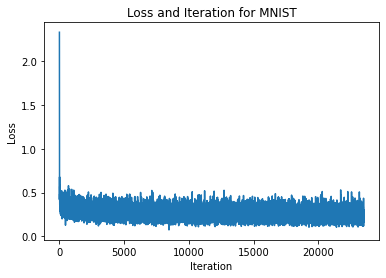

In [14]:

plt.figure()
plt.title("Loss and Iteration for MNIST")
xlabel="Iteration"
ylabel="Loss"
a=list(range(0,len(grad_norm_MNIST),1))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot(a,loss_MNIST)
plt.savefig("LOSS_MNIST_2.2.png")

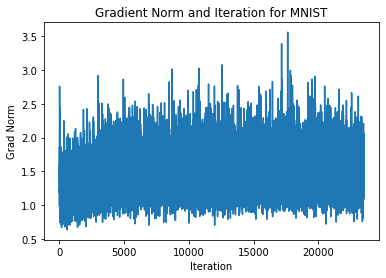

In [16]:
plt.figure()
plt.title("Gradient Norm and Iteration for MNIST")

xlabel="Iteration"
ylabel="Grad Norm"
a=list(range(0,len(grad_norm_MNIST),1))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.plot(a,grad_norm_MNIST)
plt.savefig("grad_MNIST_func2.2.png")